In [41]:
import sys
import poi_id as pid
import pprint
import pandas as pd
import numpy as np
import matplotlib
import feature_format as ff
%matplotlib inline
from collections import defaultdict
from outlier_plotter import plot_out
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
enron_data = pid.load_dataset()

## Lets take a look at how the data is laid out, which is in a nested dictionary.

In [3]:
pprint.pprint(next(iter(enron_data.items())))

('METTS MARK',
 {'bonus': 600000,
  'deferral_payments': 'NaN',
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'mark.metts@enron.com',
  'exercised_stock_options': 'NaN',
  'expenses': 94299,
  'from_messages': 29,
  'from_poi_to_this_person': 38,
  'from_this_person_to_poi': 1,
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 1740,
  'poi': False,
  'restricted_stock': 585062,
  'restricted_stock_deferred': 'NaN',
  'salary': 365788,
  'shared_receipt_with_poi': 702,
  'to_messages': 807,
  'total_payments': 1061827,
  'total_stock_value': 585062})


## We will check and see how many people are in the dataset.

In [4]:
len(enron_data)

146

## Let's see how many POI are in the dataset.

In [5]:
len([p for p in enron_data.values() if p['poi']])

18

In [6]:
print(18/146)

0.1232876712328767


## So there are 18 POI in the list out of 146 entries. That is 12% of the data.
This is not a lot to go off of, but it is the best that we have.

## Next we will check how many entries there are in the POI names list, which includes all of the POIs

In [7]:
with open('poi_names.txt', 'rb') as f:
    print(len(f.readlines()[2:]))
    f.close()

35


# Task One: Feature Selection

## Overview of available features:
### Financial Portion
- Salary - Items such as base salary, cash allowanves, benefits.
- Bonus - Annual cash incentives paid. Retention payments.
- Long Term Incentive - Cash payments from various long term incentive programs.
- Deferred Income - Voluntary executive deferalls of salary.
- Deferral Payments - Reflects distributions from a deferred compensation arrangement due to termination.
- Loan Advances - Reflects total amount of loan advances excluding repayments.
- Other - Items such as payments for severence, consulting, relocation, tax advances, allowances for internaional assignments
- Expenses - Reimbursements of business expenses.
- Director Fees - Cash payments and/or stock grants made to non-employee directors
- Exercised Stock Options - Amounts from exercised stock options which equal the markey value in excess of the exercise price
- Restricted Stock Options - Gross fair market value of shares and accrued dividends
- Restricted Stock Deferred - Value of restricted stock voluntarily deferred prior to release

### E-Mail Portion
- To Messages - Count of messages sent to person.
- From Messages - Count of messages sent by person.
- From This Person to POI - 
- Email Address- 
- From POI to This Person- 
- Shared Receipt With POI- 

### There are many features to choose from, so we will need to narrow them down.
I want to try and use the features that are not missing too many values. Let's go ahead and check the proportion of missing values for each feature.

In [8]:
missing_values = defaultdict(int)
feature_missing_check = next(iter(enron_data.values())).keys()
for person in iter(enron_data.values()):
    for feature in feature_missing_check:
        if person[feature] == 'NaN':
            missing_values[feature] += 1
missing_values = {k:round(v/len(enron_data), 3) for k,v in iter(missing_values.items())}
pprint.pprint(missing_values)

{'bonus': 0.438,
 'deferral_payments': 0.733,
 'deferred_income': 0.664,
 'director_fees': 0.884,
 'email_address': 0.24,
 'exercised_stock_options': 0.301,
 'expenses': 0.349,
 'from_messages': 0.411,
 'from_poi_to_this_person': 0.411,
 'from_this_person_to_poi': 0.411,
 'loan_advances': 0.973,
 'long_term_incentive': 0.548,
 'other': 0.363,
 'restricted_stock': 0.247,
 'restricted_stock_deferred': 0.877,
 'salary': 0.349,
 'shared_receipt_with_poi': 0.411,
 'to_messages': 0.411,
 'total_payments': 0.144,
 'total_stock_value': 0.137}


### It looks like we can get a good number of features that are have greater than 50% of their data.

In [9]:
pprint.pprint([key for key, value in iter(missing_values.items()) if value < 0.5])

['exercised_stock_options',
 'to_messages',
 'email_address',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'salary',
 'total_payments',
 'bonus',
 'expenses',
 'other',
 'restricted_stock',
 'total_stock_value']


In [10]:
pid.features_list

['poi']

In [11]:
feature_addition = ([key for key, value in iter(missing_values.items()) if value < 0.5])

In [12]:
pid.features_list.extend(feature_addition)

In [13]:
pprint.pprint(pid.features_list)

['poi',
 'exercised_stock_options',
 'to_messages',
 'email_address',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'salary',
 'total_payments',
 'bonus',
 'expenses',
 'other',
 'restricted_stock',
 'total_stock_value']


### Now we have a list containing all of the features that have greater than 50% of not null values, and also our key feature POI as the first feature in the list.

# Task Two: Outlier Identification
### From here we will go ahead and identify outliers that we want to cut from the data
### I have imported a plotting function that I made in another python file

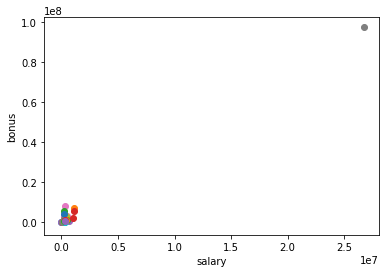

In [14]:
plot_out(enron_data, 'salary', 'bonus')

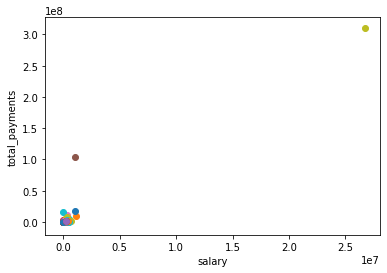

In [15]:
plot_out(enron_data, 'salary', 'total_payments')

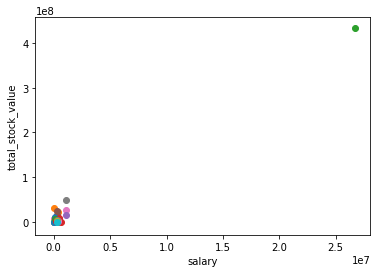

In [16]:
plot_out(enron_data, 'salary', 'total_stock_value')

### There seems to be a trend here. In every graph there is a very huge outlier. Upon further investigation of the data, this seems to be the 'Total' field. This is the values from each column added up. No wonder it is an outlier. WE will need to remove it. Also, there is a very strange entry speaking of a travel agency. We will go ahead and remove that also.

In [17]:
enron_data.pop('TOTAL', 0)

{'salary': 26704229,
 'to_messages': 'NaN',
 'deferral_payments': 32083396,
 'total_payments': 309886585,
 'loan_advances': 83925000,
 'bonus': 97343619,
 'email_address': 'NaN',
 'restricted_stock_deferred': -7576788,
 'deferred_income': -27992891,
 'total_stock_value': 434509511,
 'expenses': 5235198,
 'from_poi_to_this_person': 'NaN',
 'exercised_stock_options': 311764000,
 'from_messages': 'NaN',
 'other': 42667589,
 'from_this_person_to_poi': 'NaN',
 'poi': False,
 'long_term_incentive': 48521928,
 'shared_receipt_with_poi': 'NaN',
 'restricted_stock': 130322299,
 'director_fees': 1398517}

In [18]:
enron_data.pop('THE TRAVEL AGENCY IN THE PARK', 0)

{'salary': 'NaN',
 'to_messages': 'NaN',
 'deferral_payments': 'NaN',
 'total_payments': 362096,
 'loan_advances': 'NaN',
 'bonus': 'NaN',
 'email_address': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'deferred_income': 'NaN',
 'total_stock_value': 'NaN',
 'expenses': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'exercised_stock_options': 'NaN',
 'from_messages': 'NaN',
 'other': 362096,
 'from_this_person_to_poi': 'NaN',
 'poi': False,
 'long_term_incentive': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'restricted_stock': 'NaN',
 'director_fees': 'NaN'}

## Task Three: Create New Features
### By creating new features from exisitng features, we are able to create new and exciting ways to explore the data. Let's see if we can find any information that is going to help us out.

In [19]:
new_feature_func = [pid.from_poi, pid.to_poi, pid.shared_poi]
pid.new_feature_data(enron_data, new_feature_func);

In [20]:
pprint.pprint(pid.features_list)

['poi',
 'exercised_stock_options',
 'to_messages',
 'email_address',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'salary',
 'total_payments',
 'bonus',
 'expenses',
 'other',
 'restricted_stock',
 'total_stock_value']


In [21]:
new_feature_list = pid.features_list

In [22]:
new_feature_list

['poi',
 'exercised_stock_options',
 'to_messages',
 'email_address',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'salary',
 'total_payments',
 'bonus',
 'expenses',
 'other',
 'restricted_stock',
 'total_stock_value']

In [23]:
new_feature_list.pop()

'total_stock_value'

In [24]:
new_feature_list.pop()

'restricted_stock'

In [25]:
new_feature_list.pop()

'other'

In [26]:
new_feature_list

['poi',
 'exercised_stock_options',
 'to_messages',
 'email_address',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'salary',
 'total_payments',
 'bonus',
 'expenses']

In [27]:
new_feature_list.append('fraction_from_poi')

In [28]:
new_feature_list.append('fraction_to_poi')

In [29]:
new_feature_list.append('fraction_shared')

In [30]:
new_feature_list

['poi',
 'exercised_stock_options',
 'to_messages',
 'email_address',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'salary',
 'total_payments',
 'bonus',
 'expenses',
 'fraction_from_poi',
 'fraction_to_poi',
 'fraction_shared']

In [31]:
new_feature_list.remove('email_address')

In [32]:
from sklearn import feature_selection
selector = feature_selection.SelectKBest(score_func = feature_selection.f_classif, k = 'all')
labels, features = pid.feature_extractor(enron_data, new_feature_list)

In [33]:
selector.fit(features, labels)
pprint.pprint(sorted(zip(selector.scores_, new_feature_list[1:]), reverse = True))

[(24.25047235452619, 'exercised_stock_options'),
 (20.25718499812395, 'bonus'),
 (17.71787357924329, 'salary'),
 (15.946248696687658, 'fraction_to_poi'),
 (8.712174034323999, 'fraction_shared'),
 (8.570823078730978, 'total_payments'),
 (8.276138216260644, 'shared_receipt_with_poi'),
 (5.815328001904854, 'expenses'),
 (5.041257378669385, 'from_poi_to_this_person'),
 (2.9639903149261824, 'fraction_from_poi'),
 (2.295183195738003, 'from_this_person_to_poi'),
 (1.5425809046549228, 'to_messages'),
 (0.18121500856156128, 'from_messages')]


## I will go ahead and drop the lowest 3 scores

In [34]:
new_feature_list.remove('from_messages')
new_feature_list.remove('to_messages')
new_feature_list.remove('from_this_person_to_poi')

In [35]:
new_feature_list

['poi',
 'exercised_stock_options',
 'from_poi_to_this_person',
 'shared_receipt_with_poi',
 'salary',
 'total_payments',
 'bonus',
 'expenses',
 'fraction_from_poi',
 'fraction_to_poi',
 'fraction_shared']

### Store to my_dataset for easy testing

In [36]:
my_dataset = enron_data

In [39]:
data = ff.featureFormat(my_dataset, new_feature_list, sort_keys = True)
labels, features = ff.targetFeatureSplit(data)